# Loading in all requied packages

In [ ]:
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import pycoingecko as pycoin

# Pulling in data from CoinGecko API

In [ ]:
cg = pycoin.CoinGeckoAPI()
raw_data = cg.get_coin_market_chart_by_id(id = 'bitcoin',vs_currency= 'usd',days = 1000)
price_data = pd.json_normalize(raw_data,record_path = 'prices')
price_data['clean_date'] = pd.to_datetime(price_data[0], unit='ms')
df = price_data.copy()

# Normalizing dataset

In [36]:
del price_data['clean_date']
del price_data[0]
#print(price_data)
scaler = MinMaxScaler(feature_range=(0,1))
close_df = scaler.fit_transform(np.array(price_data).reshape(-1,1))


# Splitting the data set into a training and test DF

In [37]:
training_size = int(len(close_df)*0.9)
test_size = len(close_df)-training_size
train_data,test_data = close_df[0:training_size,:],close_df[training_size:len(close_df),:1]
print('train_data: ', train_data.shape)
print('test_data: ', test_data.shape)

train_data:  (900, 1)
test_data:  (101, 1)


# Making the test and train data matrix

In [38]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]  
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [39]:
time_step = 10 
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [40]:
# reshape input to be [samples, time steps, features] which is required for LSTMX_
train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (889, 10)
X_test:  (90, 10, 1)


# Setting the model perameters

In [41]:
model = Sequential() 
# Adding a LSTM layer with 10 internal units
model.add(LSTM(10,input_shape=(None,1),activation='relu'))
# Adding a Dense layer with 1 units.
model.add(Dense(1))
# Loss function + optimizer
model.compile(loss='mean_squared_error',optimizer='adam')

# Fitting the model

In [42]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=10,verbose=1)

Epoch 1/100
89/89 [==============================] - 2s 9ms/step - loss: 0.2305 - val_loss: 0.3153
Epoch 2/100
89/89 [==============================] - 1s 8ms/step - loss: 0.1424 - val_loss: 0.2157
Epoch 3/100
89/89 [==============================] - 0s 5ms/step - loss: 0.1141 - val_loss: 0.1721
Epoch 4/100
89/89 [==============================] - 0s 4ms/step - loss: 0.1032 - val_loss: 0.1417
Epoch 5/100
89/89 [==============================] - 0s 5ms/step - loss: 0.0977 - val_loss: 0.1226
Epoch 6/100
89/89 [==============================] - 0s 5ms/step - loss: 0.0952 - val_loss: 0.1094
Epoch 7/100
89/89 [==============================] - 0s 5ms/step - loss: 0.0940 - val_loss: 0.1003
Epoch 8/100
89/89 [==============================] - 0s 5ms/step - loss: 0.0936 - val_loss: 0.0961
Epoch 9/100
89/89 [==============================] - 0s 5ms/step - loss: 0.0936 - val_loss: 0.0933
Epoch 10/100
89/89 [==============================] - 0s 5ms/step - loss: 0.0935 - val_loss: 0.0928
Epoch 11/

# Ploting the loss function for training and validation Set.

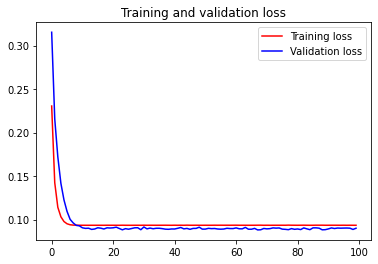

<Figure size 432x288 with 0 Axes>

In [43]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

# Making a vecotr of predicted values

In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

look_back=time_step
trainPredictPlot = np.empty_like(close_df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(close_df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(close_df)-1, :] = test_predict



# Ploting the predicted and actual Values

In [ ]:
names = cycle(['Original close price','Train predicted close price','Test predicted close price'])

plotdf = pd.DataFrame({'date': df['clean_date'],
                    'original_close': df[1],
                    'train_predicted_close' : 0 ,
                    'test_predicted_close' : 0})

plotdf['train_predicted_close'] = np.nan_to_num(scaler.inverse_transform(trainPredictPlot))
plotdf['test_predicted_close'] = np.nan_to_num(scaler.inverse_transform(testPredictPlot))

plotdf['train_predicted_close'] = plotdf['train_predicted_close'].replace(0, np.NaN)
plotdf['test_predicted_close'] = plotdf['test_predicted_close'].replace(0, np.NaN)

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],plotdf['test_predicted_close']],
                labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original vs predicted close price',
                plot_bgcolor='white',legend_title_text='Close Price')                               

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()